In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson, gaussian_kde, norm, chi2_contingency, ks_2samp
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chi2
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'
from sklearn.mixture import GaussianMixture


# Step 1: Load the data from CSV
df = pd.read_csv('casestudydata.csv')



c:\Users\beatr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


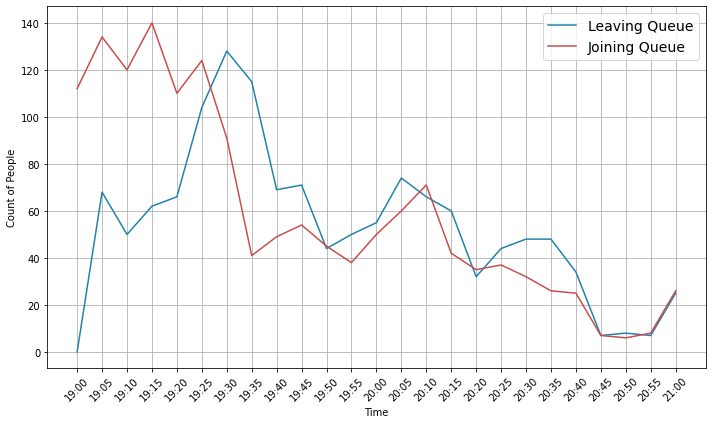

In [18]:
# Step 2: Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='time', y='Leaving Queue', label='Leaving Queue', color='#1f82ab')
sns.lineplot(data=df, x='time', y='Joining Queue', label='Joining Queue', color='#c94c4c')
plt.xlabel('Time')
plt.ylabel('Count of People')
#plt.title('Queue Dynamics Over Time')
plt.xticks(rotation=45)
plt.legend(prop={'size': 14})
plt.grid(True)
plt.tight_layout()
plt.show()


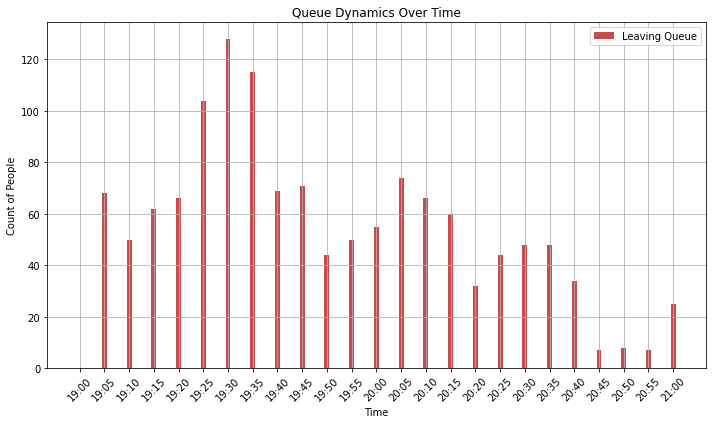

In [3]:
# Extract relevant columns
time_intervals = df['time']
people_joining = df['Joining Queue']
people_exiting = df['Leaving Queue']

# Define the Poisson distribution function
def poisson_distribution(x, lambda_):
    return poisson.pmf(x, lambda_)

# Fit the distribution to the data
#x_data = np.arange(len(time_intervals))
#popt, _ = curve_fit(poisson_distribution, x_data, people_joining)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.bar(time_intervals, people_exiting, width=0.2, color='#c94c4c', label='Leaving Queue')

# Plot the fitted distribution
#plt.plot(time_intervals, poisson_distribution(x_data, *popt) * sum(people_joining), color='#1f82ab', label='Fitted Poisson distribution')

plt.xlabel('Time')
plt.ylabel('Count of People')
plt.title('Queue Dynamics Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



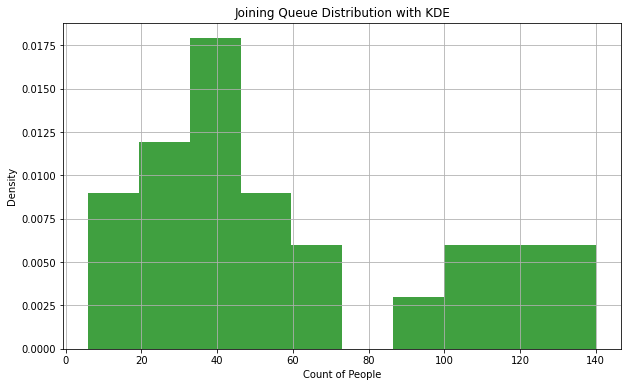

In [4]:

plt.figure(figsize=(10, 6))
sns.histplot(df['Joining Queue'], bins=10,  color='green', stat='density', linewidth=0)
plt.xlabel('Count of People')
plt.ylabel('Density')
plt.title('Joining Queue Distribution with KDE')
plt.grid(True)
plt.show()

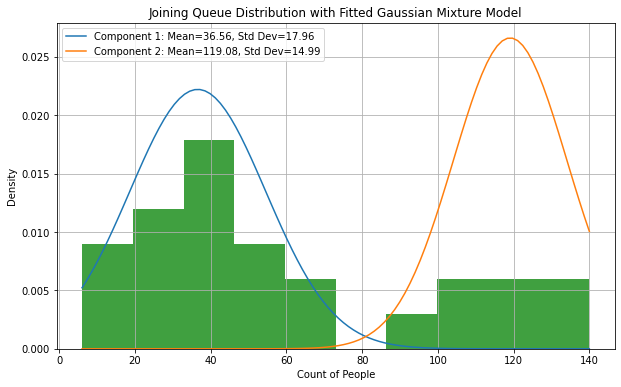

In [5]:
# Extract the relevant column
data = df['Joining Queue'].values.reshape(-1, 1)

# Custom initialization for means and covariances
initial_means = np.array([[40], [120]])  # Adjust the initial means based on your observations
initial_covariances = np.array([[[10]], [[20]]])  # Adjust the initial covariances based on your observations

# Fit Gaussian Mixture Model with two components and custom initialization
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.means_init = initial_means
gmm.covariances_init = initial_covariances
gmm.fit(data)

# Get the means and standard deviations of the components
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()


plt.figure(figsize=(10, 6))
# Plot the histogram with KDE
sns.histplot(df['Joining Queue'], bins=10, color='green', stat='density', linewidth=0)

# Plot the fitted distributions
for i in range(len(means)):
    x = np.linspace(data.min(), data.max(), 100)
    y = np.exp(-(x - means[i]) ** 2 / (2 * std_devs[i] ** 2)) / (np.sqrt(2 * np.pi) * std_devs[i])
    plt.plot(x, y, label=f'Component {i+1}: Mean={means[i]:.2f}, Std Dev={std_devs[i]:.2f}')


plt.xlabel('Count of People')
plt.ylabel('Density')
plt.title('Joining Queue Distribution with Fitted Gaussian Mixture Model')
plt.legend()
plt.grid(True)
plt.show()


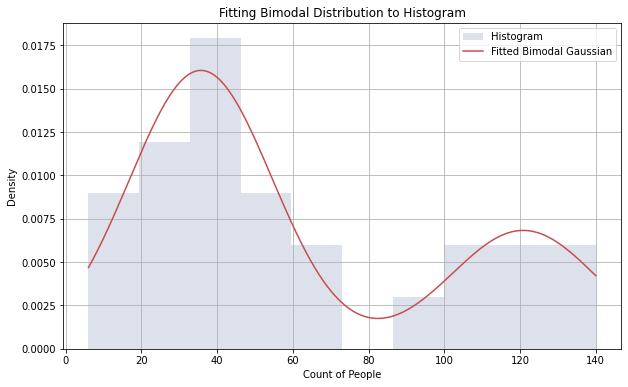

KS Statistic: 0.96
P-value: 1.1983915667747376e-07
Chi-square Statistic: 0.003710416709062242
Degrees of Freedom: 4
P-value: 0.9999982812279181


In [6]:
plt.figure(figsize=(10, 6))
# Step 1: Plot the histogram
hist_values, bin_edges, _ = plt.hist(data, bins=10, density=True, alpha=0.5, color='#bbc5da', label='Histogram')

# Step 2: Initial guess for parameters (means, std deviations, weights)
initial_guess = [36.56, 17.96, 0.7, 119.08, 14.99, 0.3]

# Step 3: Define a bimodal Gaussian function
def bimodal_gaussian(x, mean1, std_dev1, weight1, mean2, std_dev2, weight2):
    return (weight1 * np.exp(-0.5 * ((x - mean1) / std_dev1)**2) + 
            weight2 * np.exp(-0.5 * ((x - mean2) / std_dev2)**2))


# # Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Step 4: Fit the bimodal Gaussian to the histogram
popt, pcov = curve_fit(bimodal_gaussian, bin_centers, hist_values, p0=initial_guess)

# Step 5: Plot the fitted bimodal Gaussian
x_plot = np.linspace(min(data), max(data), 1000)
plt.plot(x_plot, bimodal_gaussian(x_plot, *popt), color='#c94c4c', label='Fitted Bimodal Gaussian')

# Step 6: Assess goodness of fit (optional)
# For example, perform statistical tests like KS test or chi-square test

plt.xlabel('Count of People')
plt.ylabel('Density')
plt.title('Fitting Bimodal Distribution to Histogram')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Calculate the CDF of the fitted distribution
fitted_cdf = np.cumsum(bimodal_gaussian(bin_centers, *popt))

# Step 6: Calculate the ECDF of the data
data_sorted = np.sort(data)
ecdf_data = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# Step 7: Calculate the KS statistic
ks_statistic, p_value = ks_2samp(ecdf_data, fitted_cdf)

print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

# Step 1: Calculate the expected frequencies
expected_values = bimodal_gaussian(bin_centers, *popt) * np.sum(hist_values) * np.diff(bin_edges)

# Step 2: Compute the chi-square statistic
chi2_statistic = np.sum((hist_values - expected_values)**2 / expected_values)

# Step 3: Determine the degrees of freedom
degrees_of_freedom = len(hist_values) - len(initial_guess)

# Step 4: Calculate the p-value
p_value = 1 - chi2.cdf(chi2_statistic, degrees_of_freedom)

print("Chi-square Statistic:", chi2_statistic)
print("Degrees of Freedom:", degrees_of_freedom)
print("P-value:", p_value)


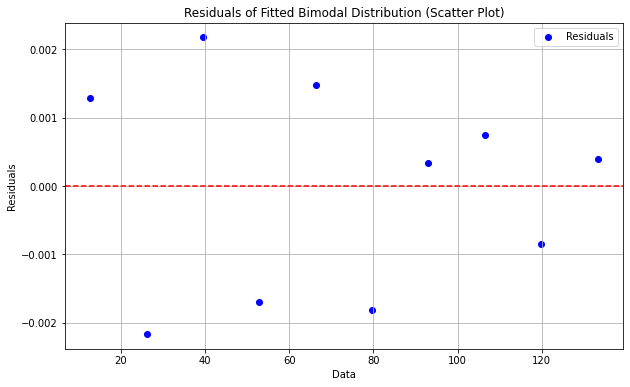

In [7]:
# Step 5: Calculate the fitted histogram values
fitted_values = bimodal_gaussian(bin_centers, *popt)

# Step 6: Calculate the residuals
residuals = hist_values - fitted_values

# Plot the residuals as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Data')
plt.ylabel('Residuals')
plt.title('Residuals of Fitted Bimodal Distribution (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.show()

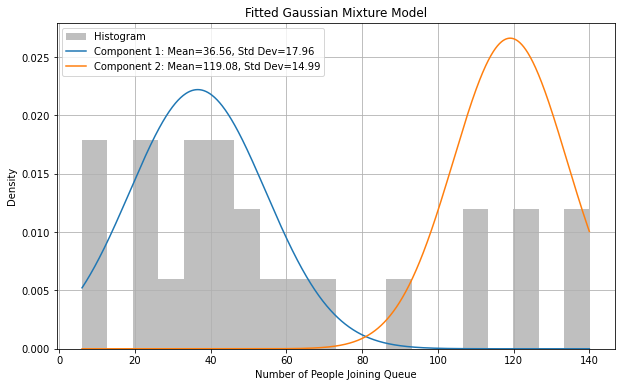

KS Statistic: 1.0
P-value: 2.2475773432443613e-50
Chi-square Statistic: 11.224001892479281
P-value: 0.9160733129319294


In [8]:
# Extract the relevant column
data = df['Joining Queue'].values.reshape(-1, 1)

# Fit Gaussian Mixture Model
#gmm = GaussianMixture(n_components=2, random_state=42)  # You can adjust the number of components based on the number of peaks
#gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42, init_params='kmeans')
# Initialize the Gaussian Mixture Model without fitting
gmm = GaussianMixture(n_components=2, random_state=42)


# Define your own initial means and covariances
your_initial_means = np.array([[40], [120]])  # Example initial means
your_initial_covariances = np.array([[[20]], [[30]]])  # Example initial covariances

# Set the initial means and covariances
gmm.means_init = your_initial_means
gmm.covariances_init = your_initial_covariances

# Fit the model to your data
gmm.fit(data)

gmm.fit(data)

# Get the means and standard deviations of the components
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=20, density=True, alpha=0.5, color='gray', label='Histogram')

# Plot the fitted distributions
for i in range(len(means)):
    x = np.linspace(data.min(), data.max(), 1000)
    y = np.exp(-(x - means[i]) ** 2 / (2 * std_devs[i] ** 2)) / (np.sqrt(2 * np.pi) * std_devs[i])
    plt.plot(x, y, label=f'Component {i+1}: Mean={means[i]:.2f}, Std Dev={std_devs[i]:.2f}')

plt.xlabel('Number of People Joining Queue')
plt.ylabel('Density')
plt.title('Fitted Gaussian Mixture Model')
plt.legend()
plt.grid(True)
plt.show()

# Get the PDF values for the fitted GMM
pdf_values = gmm.score_samples(data)
pdf = np.exp(pdf_values)

# Calculate the ECDF for the observed data
ecdf_observed = np.cumsum(np.histogram(df['Joining Queue'], bins=1000, density=True)[0])

# Calculate the CDF of the fitted Gaussian mixture model
cdf_fitted = np.cumsum(pdf) * np.diff(x)[0]

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ecdf_observed, cdf_fitted)

print("KS Statistic:", ks_statistic)
print("P-value:", p_value)


# Calculate observed frequencies
observed, _ = np.histogram(data, bins=20)

# Calculate expected frequencies using the PDF values
expected = pdf * len(data)

# Adjust the lengths of observed and expected arrays
min_length = min(len(observed), len(expected))
observed = observed[:min_length]
expected = expected[:min_length]

# Reshape observed and expected frequencies to have the same shape
observed = observed.reshape(-1, 1)
expected = expected.reshape(-1, 1)

# Perform chi-square test
chi2_statistic, p_value, *_ = chi2_contingency(np.hstack((observed, expected)))

print("Chi-square Statistic:", chi2_statistic)
print("P-value:", p_value)

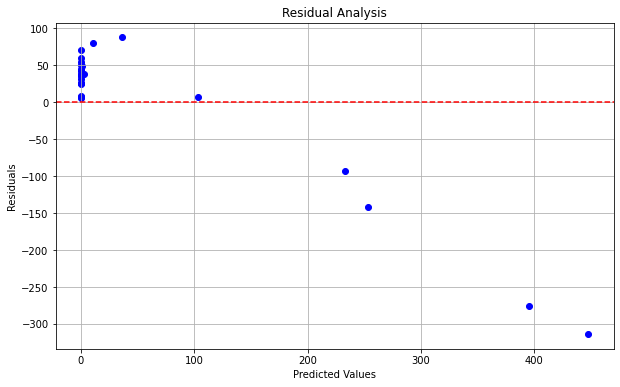

In [9]:
# Load data
df = pd.read_csv('casestudydata.csv')

# Extract relevant columns
time_intervals = df['time']
people_joining = df['Joining Queue']

# Define the Poisson distribution function
def poisson_distribution(x, lambda_):
    return poisson.pmf(x, lambda_)

# Fit the distribution to the data
x_data = np.arange(len(time_intervals))
popt, _ = curve_fit(poisson_distribution, x_data, people_joining)

# Calculate expected values from the fitted distribution
expected_values = poisson_distribution(x_data, *popt) * sum(people_joining)

# Calculate residuals
residuals = people_joining - expected_values

# Plot residuals against predicted values
plt.figure(figsize=(10, 6))
plt.scatter(expected_values, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.show()

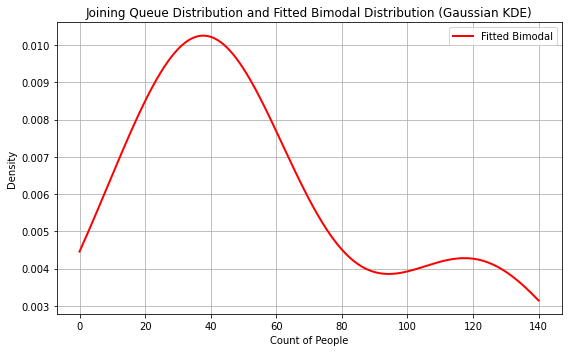

KS Statistic: 0.986
P-value: 0.000000000000000000000000000000


In [10]:
# Fit a bimodal distribution (Gaussian Kernel Density Estimation) to the "Joining Queue" data
kde = gaussian_kde(df['Joining Queue'])

# Generate points along the x-axis for plotting the fitted distributions
x = np.linspace(0, df['Joining Queue'].max(), 1000)

# Calculate the probability densities for the fitted distributions
pdf = kde(x)

# Plot the histogram of the "Joining Queue" data and the fitted bimodal distribution
plt.figure(figsize=(8, 5))
#sns.histplot(df['Joining Queue'], bins=10, kde=True, color='green', stat='density', linewidth=0)
plt.plot(x, pdf, color='red', linestyle='-', linewidth=2)
plt.xlabel('Count of People')
plt.ylabel('Density')
plt.title('Joining Queue Distribution and Fitted Bimodal Distribution (Gaussian KDE)')
plt.legend(['Fitted Bimodal', 'Joining Queue'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the empirical cumulative distribution function (ECDF) for the observed data
ecdf_observed = np.cumsum(np.histogram(df['Joining Queue'], bins=1000, density=True)[0])

# Calculate the CDF of the fitted distribution (KDE)
cdf_fitted = np.cumsum(pdf) * np.diff(x)[0]

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ecdf_observed, cdf_fitted)

print("KS Statistic:", ks_statistic)
print("P-value: {:.30f}".format(p_value))




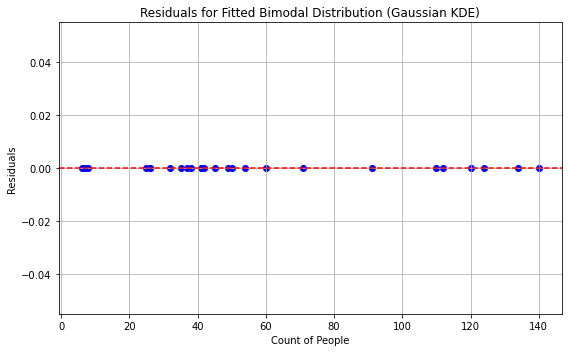

In [11]:
# Fit a bimodal distribution (Gaussian Kernel Density Estimation) to the "Joining Queue" data
kde = gaussian_kde(df['Joining Queue'])

# Calculate the observed densities for each data point
observed_densities = kde(df['Joining Queue'])

# Generate points along the x-axis for plotting the fitted distributions
x = np.linspace(0, df['Joining Queue'].max(), len(observed_densities))

# Calculate the probability densities for the fitted distributions at the observed data points
pdf = kde(df['Joining Queue'])

# Calculate the residuals
residuals = observed_densities - pdf

# Plot the residuals
plt.figure(figsize=(8, 5))
plt.scatter(df['Joining Queue'], residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Count of People')
plt.ylabel('Residuals')
plt.title('Residuals for Fitted Bimodal Distribution (Gaussian KDE)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Calculate the empirical cumulative distribution function (ECDF) for the observed data
ecdf_observed = np.cumsum(np.histogram(df['Joining Queue'], bins=1000, density=True)[0])

# Calculate the CDF of the fitted distribution
cdf_fitted = np.cumsum(pdf) * np.diff(x)[0]

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ecdf_observed, cdf_fitted)

print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.859
P-value: 7.497032551068588e-21


In [13]:
# Binning the data (adjust the number and width of bins as needed)
bins = np.arange(0, df['Joining Queue'].max(), 20)

# Calculating observed frequencies
observed, _ = np.histogram(df['Joining Queue'], bins=bins)

# Fitting the bimodal distribution (e.g., Gaussian KDE)
kde = gaussian_kde(df['Joining Queue'])

# Calculating expected frequencies based on the fitted distribution
bin_centers = (bins[1:] + bins[:-1]) / 2
expected = np.diff(bins) * np.sum(kde(bin_centers))

# Reshape observed and expected frequencies into a contingency table
contingency_table = np.array([observed, expected])

# Performing the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi-square test statistic:", chi2)
print("p-value:", p_value)



Chi-square test statistic: 1.607141827096384
p-value: 0.9003843386701453


In [14]:
# Fit a Poisson distribution to the "Joining Queue" data
mu = df['Joining Queue'].mean()  # Estimate the parameter lambda for the Poisson distribution
poisson_dist = poisson(mu)

# Fit a bimodal distribution (Gaussian Kernel Density Estimation) to the "Joining Queue" data
kde = gaussian_kde(df['Joining Queue'])

# Calculate the log-likelihood of each model
log_likelihood_poisson = np.sum(np.log(poisson_dist.pmf(df['Joining Queue'])))
log_likelihood_bimodal = np.sum(np.log(kde.pdf(df['Joining Queue'])))

# Calculate the number of parameters for each model
num_parameters_poisson = 1  # Poisson distribution has one parameter (lambda)
num_parameters_bimodal = 2 * len(kde.resample(1000))  # Number of parameters for Gaussian KDE is twice the number of data points

# Calculate AIC and BIC for each model
n = len(df['Joining Queue'])
aic_poisson = -2 * log_likelihood_poisson + 2 * num_parameters_poisson
aic_bimodal = -2 * log_likelihood_bimodal + 2 * num_parameters_bimodal
bic_poisson = -2 * log_likelihood_poisson + np.log(n) * num_parameters_poisson
bic_bimodal = -2 * log_likelihood_bimodal + np.log(n) * num_parameters_bimodal

# Print the AIC and BIC values for both models
print("Poisson distribution:")
print("AIC:", aic_poisson)
print("BIC:", bic_poisson)
print()
print("Bimodal distribution (Gaussian KDE):")
print("AIC:", aic_bimodal)
print("BIC:", bic_bimodal)

Poisson distribution:
AIC: 842.6725489539918
BIC: 843.89142477886

Bimodal distribution (Gaussian KDE):
AIC: 252.90383846995317
BIC: 255.34159011968958
